In [64]:
import numpy as np
import pathlib
import skimage
import matplotlib.pyplot as plt
ddir = pathlib.Path("data/SUIM/data")
print(f"We expect the data files in directory {ddir.absolute()}")

We expect the data files in directory d:\Library\Downloads\Documents\School\SUPSI_23-24\deep_learning\notebooks\data\SUIM\data


In [65]:
def read_image(name, set_="train_val", im_type="images"):
    return skimage.io.imread(pathlib.Path(ddir, set_, im_type, name))

def get_images(set_="train_val", im_type="images"):
    return [read_image(file.name, set_, im_type) 
            for file in pathlib.Path(ddir, set_, im_type).iterdir() 
            if file.is_file()]
    
def get_filenames(set_="train_val", im_type="images"):
    return [file.name[:-4]
            for file in pathlib.Path(ddir, set_, im_type).iterdir() 
            if file.is_file()]

In [66]:
masks_train = get_images("train_val", "masks")
masks_test = get_images("test", "masks")
ims_train = get_images("train_val", "images")
ims_test = get_images("test", "images")

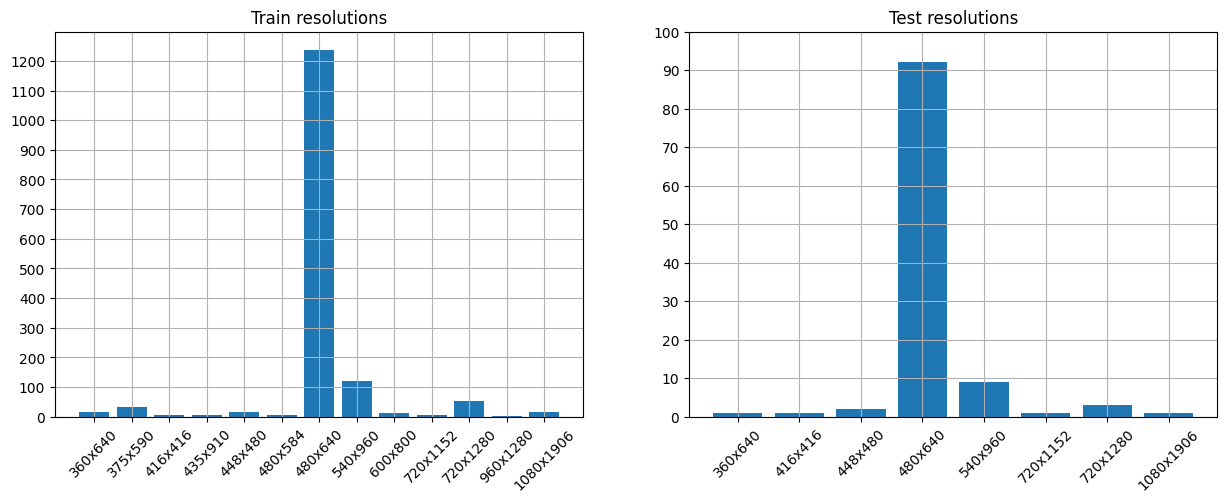

In [67]:
# plot image resolution in bar chart
resolutions_train = ['x'.join(str(i) for i in r) for r in sorted(map(lambda im: (im.shape[0], im.shape[1]),ims_train))]
resolutions_test = ['x'.join(str(i) for i in r) for r in sorted(map(lambda im: (im.shape[0], im.shape[1]),ims_test))]

fig,axes = plt.subplots(1,2,figsize=(15,5))

def plot_res(resolutions,title,i):
    unique_res = [x for i, x in enumerate(resolutions) if x not in resolutions[:i]]
    res_count = [resolutions.count(x) for x in unique_res]
    axes[i].bar(unique_res, res_count)
    axes[i].set_title(title)
    axes[i].grid(True)
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

plot_res(resolutions_train,'Train resolutions',0)
axes[0].set_yticks(np.arange(0, 1300, 100))
plot_res(resolutions_test,'Test resolutions',1)
axes[1].set_yticks(np.arange(0, 110, 10))

In [68]:
# check resolutions percentage
non_480x640_res_train = [(x.shape[0],x.shape[1]) for x in ims_train if x.shape != (480, 640,3)]
non_480x640_res_test = [(x.shape[0],x.shape[1]) for x in ims_test if x.shape != (480, 640,3)]
unique_res = set([(x.shape[0],x.shape[1]) for x in ims_train])
print("------------------train------------------")
print(f"unique resolutions in train: {unique_res}")
print(f"different from resolutions from 480x 640 in train: {len(non_480x640_res_train)}")
print(f"percentage of total {round((len(non_480x640_res_train)/len(ims_train))*100,2)}")

print("------------------test------------------")
print(f"different from resolutions from 480x 640 in test: {len(non_480x640_res_test)}")
print(f"percentage of total {round((len(non_480x640_res_test)/len(ims_test))*100,2)}")

------------------train------------------
unique resolutions in train: {(960, 1280), (720, 1280), (435, 910), (448, 480), (1080, 1906), (480, 584), (375, 590), (360, 640), (600, 800), (416, 416), (540, 960), (480, 640), (720, 1152)}
different from resolutions from 480x 640 in train: 288
percentage of total 18.89
------------------test------------------
different from resolutions from 480x 640 in test: 18
percentage of total 16.36


In [69]:
def get_fish_pixel(im):
    return np.sum(im == [1, 1, 0])

def get_size(im):
    return im.shape[0] * im.shape[1]

In [70]:
total_fish_pixels = sum(map(get_fish_pixel, masks_train))
total_pixels = sum(map(get_size, masks_train))
print("------------------train------------------")
print(f"fish pixels: {total_fish_pixels}, "
      f"total pixels: {total_pixels}, " 
      f"{round((total_fish_pixels/total_pixels)*100,2)}% fish pixels in train")

total_fish_pixels = sum(map(get_fish_pixel, masks_test))
total_pixels = sum(map(get_size, masks_test))
print("------------------test------------------")
print(f"fish pixels: {total_fish_pixels}, "
      f"total pixels: {total_pixels}, " 
      f"{round((total_fish_pixels/total_pixels)*100,2)}% fish pixels in test")

------------------train------------------
fish pixels: 236564523, total pixels: 558040644, 42.39% fish pixels in train
------------------test------------------
fish pixels: 20714898, total pixels: 39414256, 52.56% fish pixels in test


In [78]:
# create 20000? patches of fish and non-fish centered size 100x100
# save to data/SUIM/test/patches

# should we resize the images before creating the patches?
# or drop sizes that differ? (we would lose 19% of the data)

# change to X (10?) patches per image instead of 1

def find_patch(path, size=100, random=True):
    im = skimage.io.imread(path)
    x = np.random.randint(0, im.shape[0]-size)
    y = np.random.randint(0, im.shape[1]-size)
    if not random:
        # need faster way probably just for loop over the image
        while not np.all(im[x+size//2, y+size//2] == [1, 1, 0]):
            x = np.random.randint(0, im.shape[0]-size)
            y = np.random.randint(0, im.shape[1]-size)

    mask_patch = im[x:x+size, y:y+size]
    return x,y,mask_patch

def create_patches(set_="train_val",size=100,random=True):
    type_ = "rnd" if random else "fish"
    filenames = get_filenames(set_)
    file = np.random.choice(filenames)
    
    x,y,mask_patch = find_patch(pathlib.Path(ddir, set_, "masks", f"{file}.bmp"),size=size, random=random)
    image_patch = read_image(f"{file}.jpg", set_, "images")[x:x+size, y:y+size]
    
    skimage.io.imsave(pathlib.Path(ddir, set_, "patches", "masks", f"{file}patch_{type_}.bmp"), mask_patch)
    skimage.io.imsave(pathlib.Path(ddir, set_, "patches", "images", f"{file}patch_{type_}.jpg"), image_patch)

#create random patches
for i in range(100):
    create_patches("train_val", random=True)
    
#create fish patches
for i in range(10): 
    create_patches("train_val", random=False)

KeyboardInterrupt: 